# Setup

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: ROI_env
python version: 3.8.12


In [2]:
%load_ext autoreload
%autoreload 2

import importlib.util
import glob
import pathlib
from pathlib import Path
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedShuffleSplit
import scipy.stats
import scipy.signal
from kymatio import Scattering2D
import json
import torchvision
import torch
from tqdm.notebook import tqdm, trange
import sys
import pickle
import pandas as pd
import shutil
import h5py
# import figgen as fg
import sys
import time
import gc
import numpy as np

print('Numpy Version:', np.__version__)
# print('TorchVision Version:',torchvision.__version__)

dir_github = Path(r'/Users/josh/Documents/github_repos/').resolve()
# dir_github = Path(r'/n/data1/hms/neurobio/sabatini/josh/github_repos/').resolve()

import sys
sys.path.append(str(dir_github))

from ROICaT.roicat import helpers, ROInet
# from ROICaT.roicat.tracking import data_importing, visualization, alignment, blurring, ROInet, scatteringWaveletTransformer, similarity_graph, clustering
from ROICaT.roicat.classification import data, evaluate, visualize, pipeline, crossval
import multiprocessing as mp

Numpy Version: 1.20.3


In [3]:
tic = time.time()
toc = {}
toc['start'] = time.time() - tic

# Import Paths

In [4]:
def spr(*directory_list):
    for dir_num, directory in enumerate(directory_list):
        if dir_num == 0:
            full_directory = Path(directory)
        else:
            full_directory = full_directory / directory
    return str(full_directory.resolve())

In [5]:
def print_list(l):
    for item in l:
        print(item)

In [6]:
# dir_allOuterFolders = Path(r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16").resolve()
# # dir_allOuterFolders = Path(r"/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files").resolve()

# folders_allSessions = natsort.natsorted(helpers.get_dir_contents(dir_allOuterFolders)[0])

# dir_allS2pFolders = [dir_allOuterFolders / folder for folder in folders_allSessions]

# pathSuffixToStat = 'plane0/stat.npy'
# pathSuffixToOps = 'plane0/ops.npy'
# # pathSuffixToStat = 'stat.npy'
# # pathSuffixToOps = 'ops.npy'

# paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])[:]
# paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])[:]
# # paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])
# # paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])

# print(f'folder names of all sessions: \n{folders_allSessions}')
# print(f'paths to all stat files: \n{paths_allStat}')


# ---------------------------------------
# || Specify Raw Data Filename Sources ||
# ---------------------------------------
stat_files = spr('/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/data/training/mouse2_6__20210409/stat.npy')
label_files = spr('/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/data/training/mouse2_6__20210409/labels_round2_sesh2.npy')

# Import Data

In [7]:
dat = data.Data(
    paths_statFiles=stat_files,
    paths_labelFiles=label_files,
    um_per_pixel=1.0,
    verbose=True,
)

dat.import_statFiles();
dat.import_labelFiles();

# data.import_ROI_spatialFootprints(workers=-1);

Starting: Importing spatial footprints from stat files


FileNotFoundError: [Errno 2] No such file or directory: '/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/data/training/mouse2_6__20210409/stat.npy'

In [8]:
# %matplotlib notebook

# # From ROICaT
# visualization.display_toggle_image_stack(np.concatenate(data.ROI_images, axis=0))

In [9]:
toc['import_data'] = time.time() - tic

# Concatenate / Adjust / Clean Data + Drop Non-Nans

In [10]:
dat.drop_nan_rois();

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

# Neural Network Embeddings

In [11]:
hash_dict_true = {
    'params': ('params.json', '68cf1bd47130f9b6d4f9913f86f0ccaa'),
    'model': ('model.py', '61c85529b7aa33e0dfadb31ee253a7e1'),
    'state_dict': ('ConvNext_tiny__1_0_best__simCLR.pth', '3287e001ff28d07ada2ae70aa7d0a4da'),
}

roinet = ROInet.ROInet_embedder(
    device='cuda:0',
#     dir_networkFiles='/home/rich/Downloads/ROInet',
    dir_networkFiles='/n/data1/hms/neurobio/sabatini/josh/analysis/roinet-paper/ROICaT',
    
#     download_from_gDrive='force_download',
#     download_from_gDrive='force_local',
    download_from_gDrive='check_local_first',
    gDriveID='1D2Qa-YUNX176Q-wgboGflW0K6un7KYeN',
    hash_dict_networkFiles=hash_dict_true,
#     hash_dict_networkFiles=None,
    forward_pass_version='latent',
    verbose=True,
)

roinet.generate_dataloader(
    ROI_images=[dat.statFiles],
    um_per_pixel=dat.um_per_pixel,
    pref_plot=False,
    batchSize_dataloader=8,
    pinMemory_dataloader=True,
    numWorkers_dataloader=mp.cpu_count(),
    persistentWorkers_dataloader=True,
    prefetchFactor_dataloader=2,    
);

roinet.generate_latents();

# roinet.latents
# roinet.dataset
# roinet.net
# roinet.params_model

params.json not found in test directory: /n/data1/hms/neurobio/sabatini/josh/analysis/roinet-paper/ROICaT.
model.py not found in test directory: /n/data1/hms/neurobio/sabatini/josh/analysis/roinet-paper/ROICaT.
ConvNext_tiny__1_0_best__simCLR.pth not found in test directory: /n/data1/hms/neurobio/sabatini/josh/analysis/roinet-paper/ROICaT.
Hash comparison failed. Downloading from Google Drive.


Retrieving folder list


Processing file 1Cj87Hk2Nk3RJVDihMhC011bxUNfJFlzk ConvNext_tiny__1_0_best__simCLR.pth
Processing file 1WalPTXyWunVa8d6Py1vjZs0yNd4qmR4k model.py
Processing file 1RbuDNIRRH70O92tKVb7bFw5WeUG1bgU2 params.json
Processing file 1wq2abtTPUBH4HDWn1Nnv5f9DGs7sN8q5 ReadMe.txt


Retrieving folder list completed
Building directory structure


OSError: [Errno 30] Read-only file system: '/n'

In [13]:
# latents = (roinet.latents)
# labelFiles = dat.labelFiles

latents = np.load('/Users/josh/Downloads/data_backup_save/latents.npy')
labelFiles = np.load('/Users/josh/Downloads/data_backup_save/labelFiles.npy')

In [14]:
# np.load('/n/data1/hms/neurobio/sabatini/josh/analysis/data_backup_save/latents.npy')

In [15]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

In [16]:
toc['NN'] = time.time() - tic

# UMAP Embeddings

In [17]:
umap_params = dict(
    n_neighbors=30,
    n_components=2,
    metric='euclidean',
    metric_kwds=None,
    output_metric='euclidean',
    output_metric_kwds=None,
    n_epochs=None,
    learning_rate=1.0,
    init='spectral',
    min_dist=0.1,
    spread=1.0,
    low_memory=True,
    n_jobs=-1,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
    repulsion_strength=1.0,
    negative_sample_rate=5,
    transform_queue_size=4.0,
    a=None,
    b=None,
    random_state=None,
    angular_rp_forest=False,
    target_n_neighbors=-1,
    target_metric='categorical',
    target_metric_kwds=None,
    target_weight=0.5,
    transform_seed=42,
    transform_mode='embedding',
    force_approximation_algorithm=False,
    verbose=False,
    tqdm_kwds=None,
    unique=False,
    densmap=False,
    dens_lambda=2.0,
    dens_frac=0.3,
    dens_var_shift=0.1,
    output_dens=False,
    disconnection_distance=None,
    precomputed_knn=(None, None, None),
)

umap = UMAP(**umap_params)
print('Fitting UMAP...')
umap.fit(latents)
print('Generating Embeddings...')
embeddings = umap.transform(latents)
print('Embeddings Generated...')

Fitting UMAP...


OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Generating Embeddings...
Embeddings Generated...


# Visualize Embeddings

In [18]:
# roinet.latents.shape, labelFiles.shape

<IPython.core.display.Javascript object>


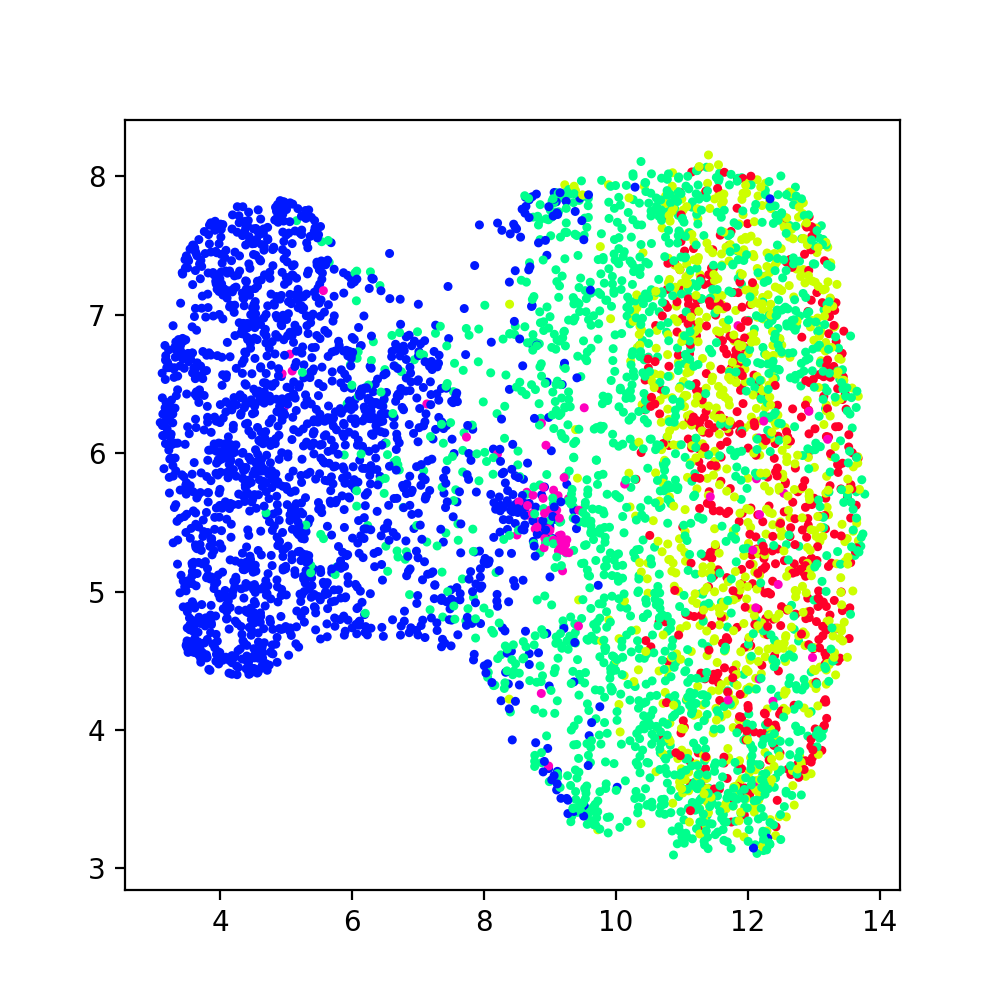

In [19]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(embeddings[:,0], embeddings[:,1], s=5, c=labelFiles[:], cmap='gist_rainbow')

In [68]:
toc['visualize'] = time.time() - tic

## Train/Holdout Split

In [69]:
from sklearn.model_selection import train_test_split
train_inx, holdout_inx = train_test_split(np.arange(latents.shape[0]), test_size=0.3)

In [70]:
features_train, features_holdout, labels_train, labels_holdout = (latents[train_inx],
                                                                  latents[holdout_inx],
                                                                  labelFiles[train_inx],
                                                                  labelFiles[holdout_inx],)

# Create Pipeline / Classifier

In [71]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

preproc = make_pipeline(
    StandardScaler(),
    PCA(),
)

preproc.fit(features_train, labels_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA())])

# Cross-Validation

In [72]:
splitter = ShuffleSplit(n_splits=10)
cv = crossval.CrossValidation(splitter)
cv.split_to_inx(features_train)
cv.inx_to_data(features_train, labels_train)

In [73]:
classifier_kwargs = dict(solver='lbfgs', fit_intercept=True,  class_weight='balanced', max_iter=10000)
cv_dct = crossval.split_loop_c(cv, preproc, classifier_kwargs, preproc_refit=False, c_lst=[1, 0.1, 0.01])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


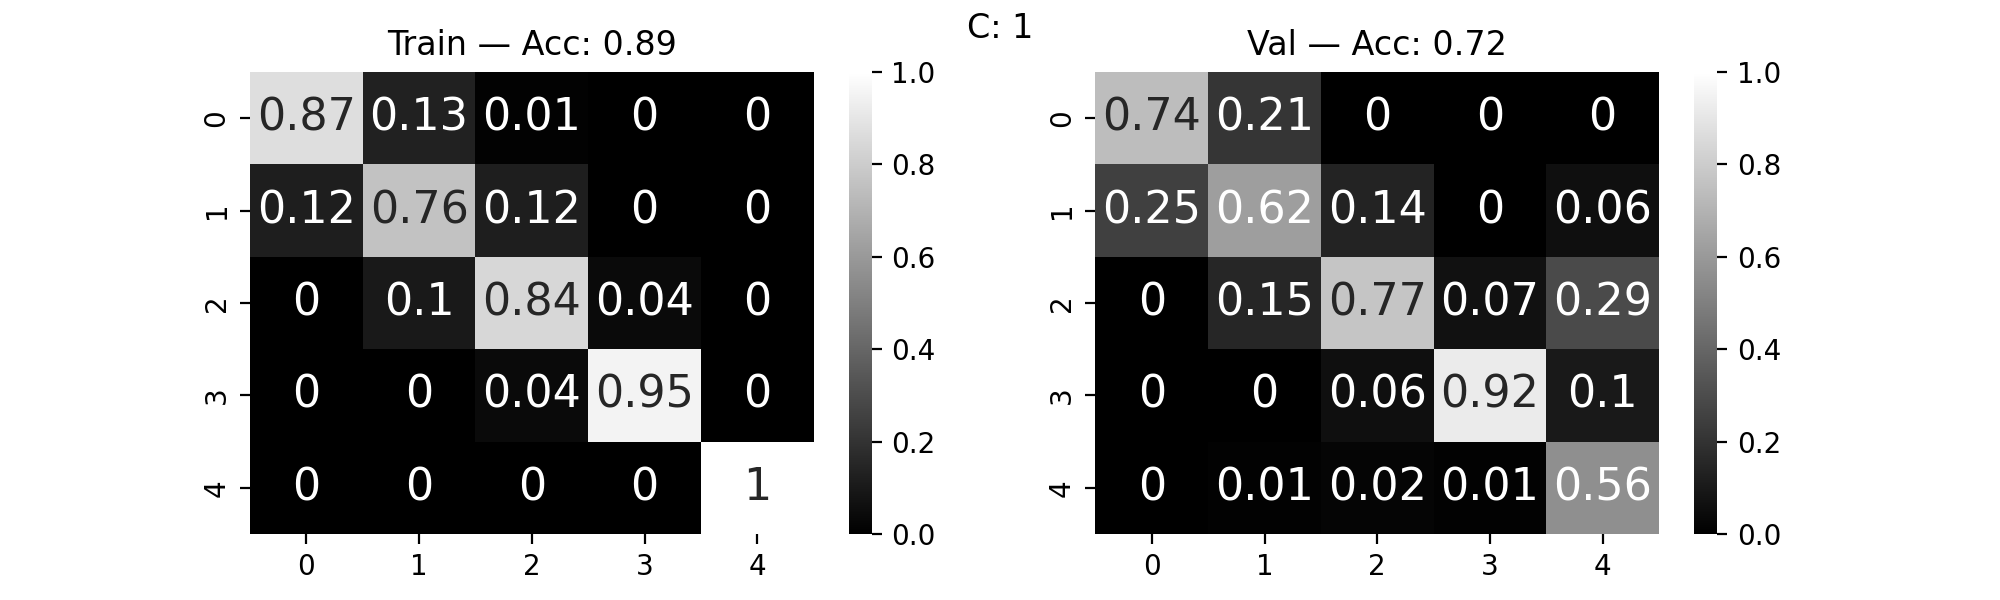

<IPython.core.display.Javascript object>


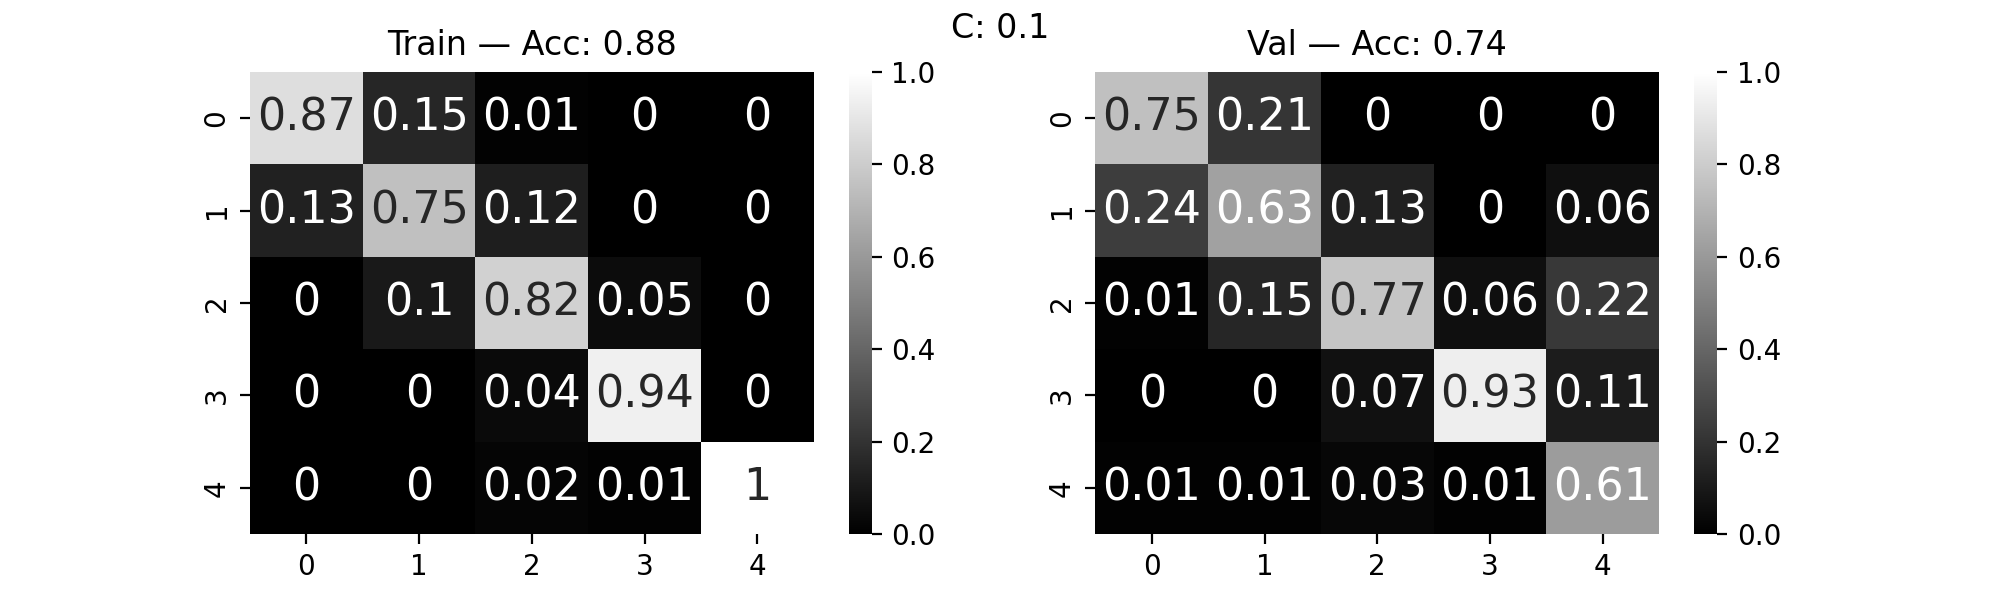

<IPython.core.display.Javascript object>


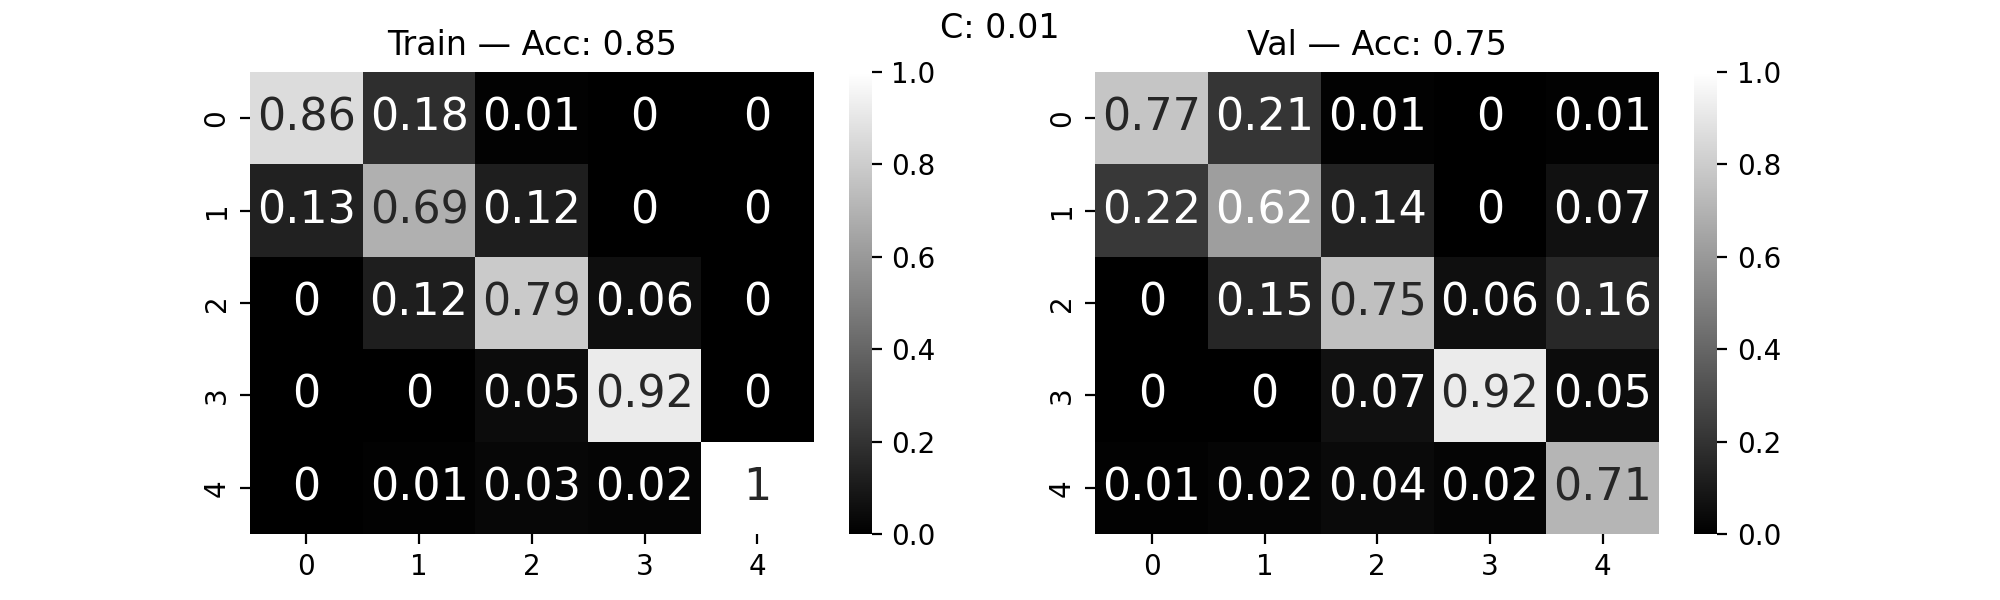

In [74]:
crossval.view_cv_dict(cv_dct)

# Refit Classifier

In [75]:
preproc = make_pipeline(
    StandardScaler(),
    PCA(),
)

classify = LogisticRegression(
    solver='lbfgs',
    fit_intercept=True, 
    class_weight='balanced',
    max_iter=10000,
    C=1
)


pipe = pipeline.fit_pipe(features_train, labels_train, preproc, classify, preproc_refit=True)

# Evaluate Classifier

<IPython.core.display.Javascript object>


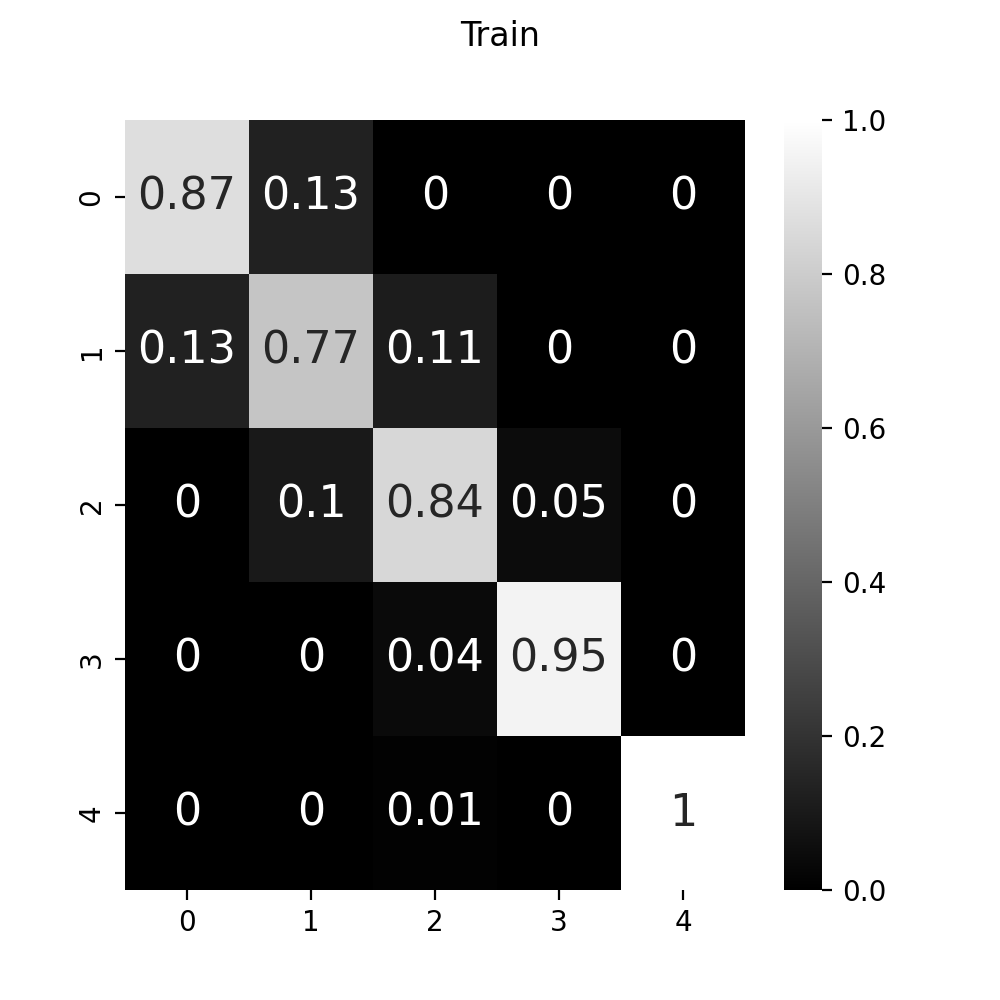

Text(0.5, 0.98, 'Train')

In [76]:
evaluator = evaluate.Evaluation(pipe.pipeline)
cm = evaluator.confusion_matrix(features_train, labels_train)
cm = np.round(cm, 2)
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'), ax=ax)
fig.suptitle('Train')

<IPython.core.display.Javascript object>


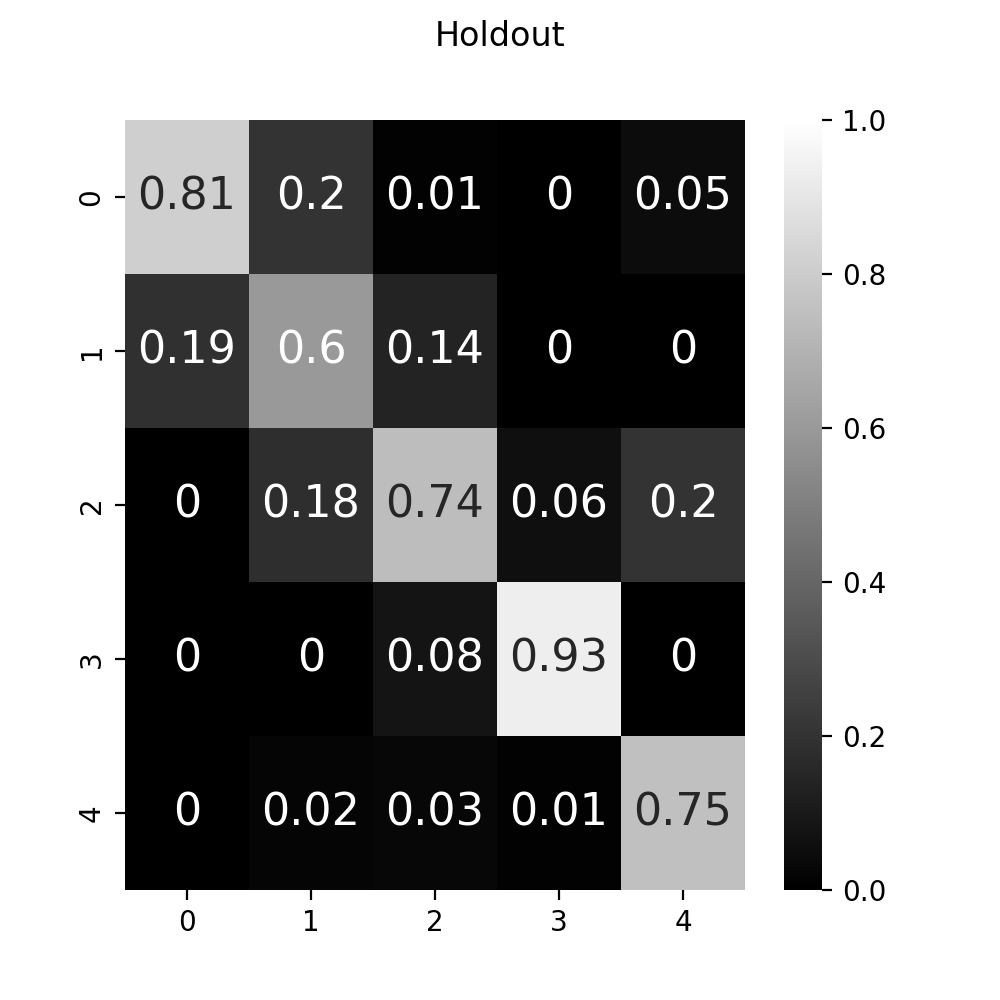

Text(0.5, 0.98, 'Holdout')

In [77]:
evaluator = evaluate.Evaluation(pipe.pipeline)
cm = evaluator.confusion_matrix(features_holdout, labels_holdout)
cm = np.round(cm, 2)
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'), ax=ax)
fig.suptitle('Holdout')

# Refit Model with Different Numbers of Examples

<IPython.core.display.Javascript object>


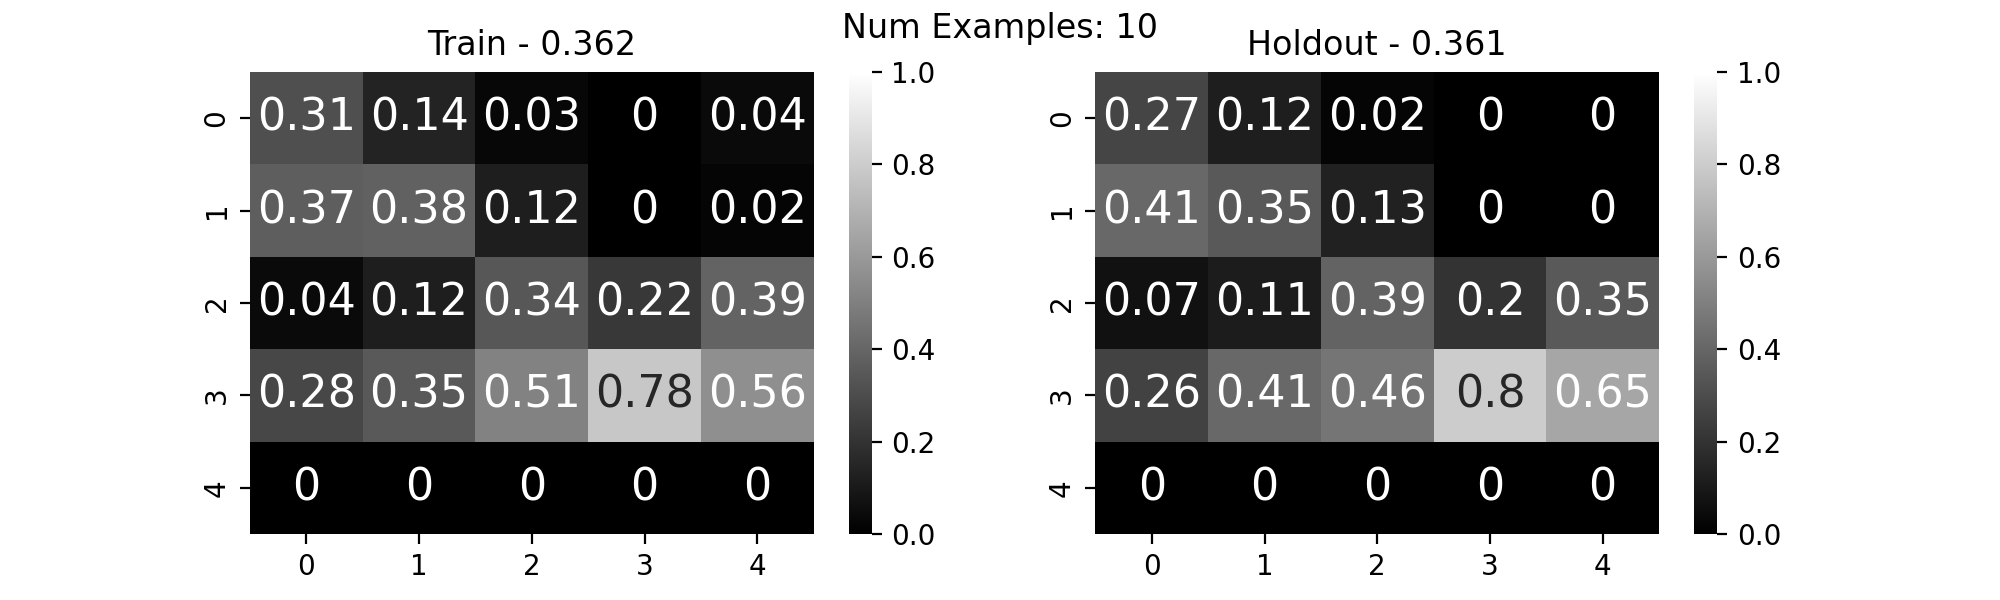

<IPython.core.display.Javascript object>


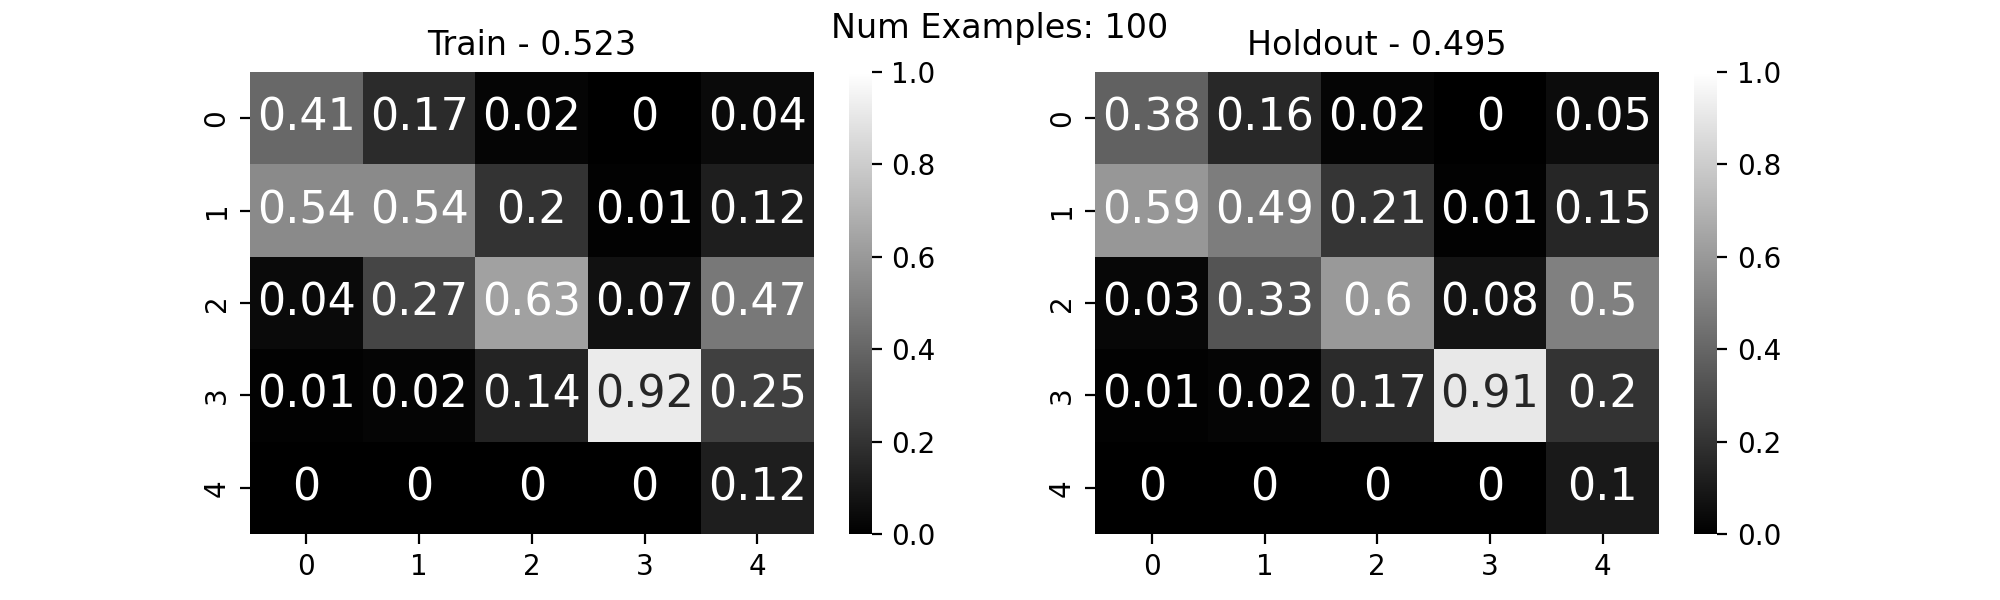

<IPython.core.display.Javascript object>


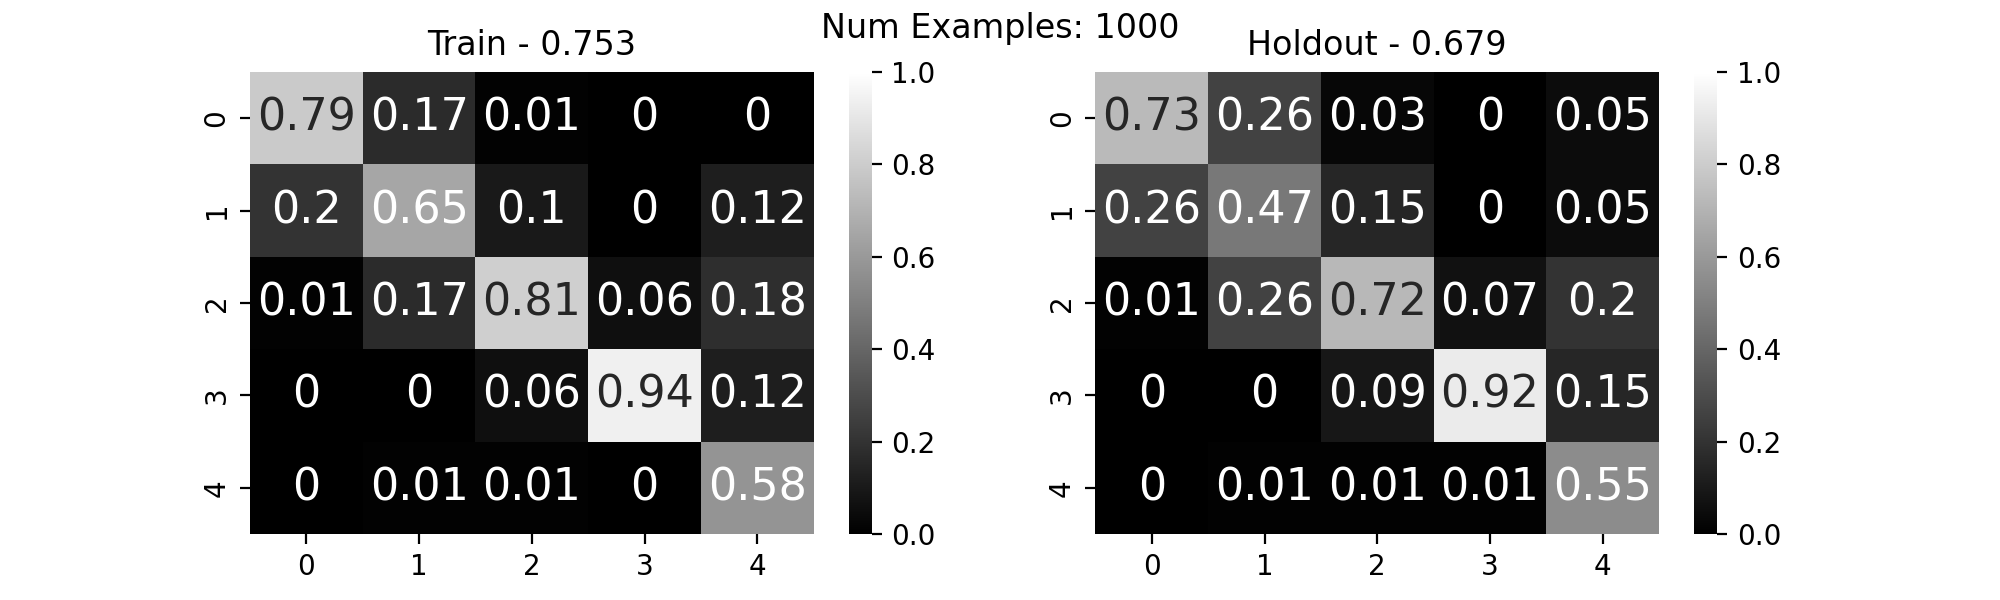

<IPython.core.display.Javascript object>


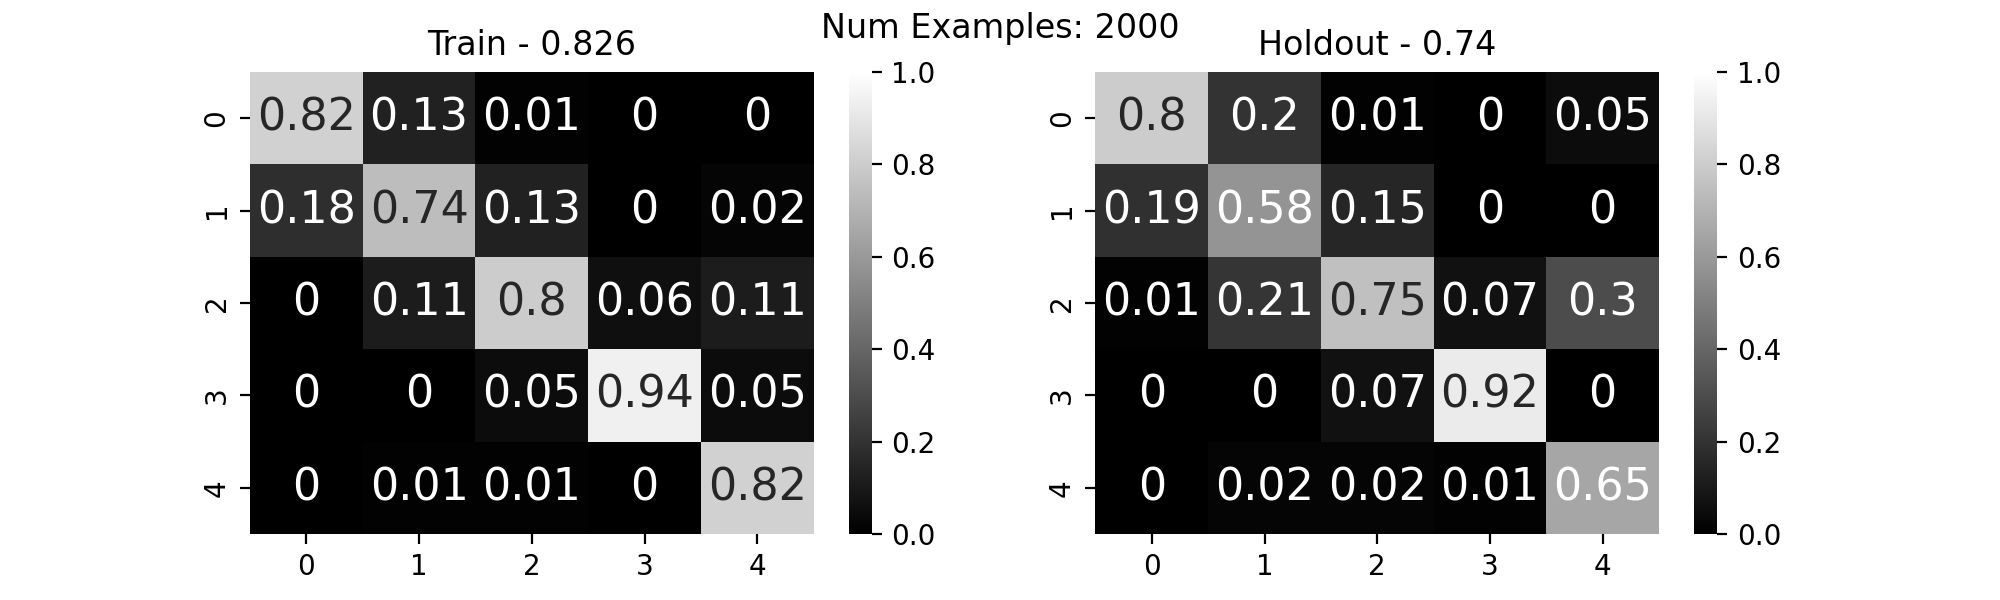

<IPython.core.display.Javascript object>


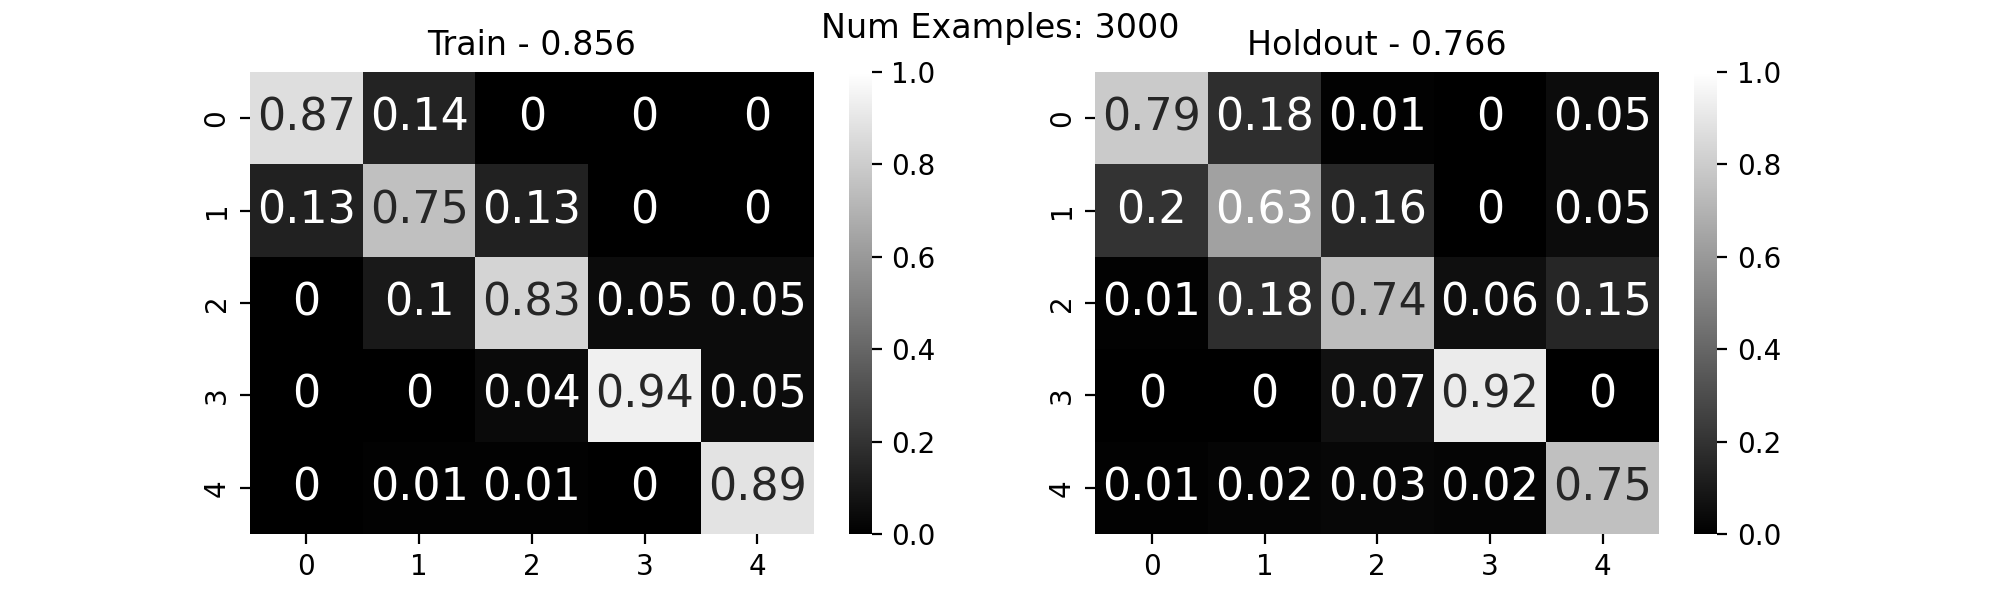

<IPython.core.display.Javascript object>


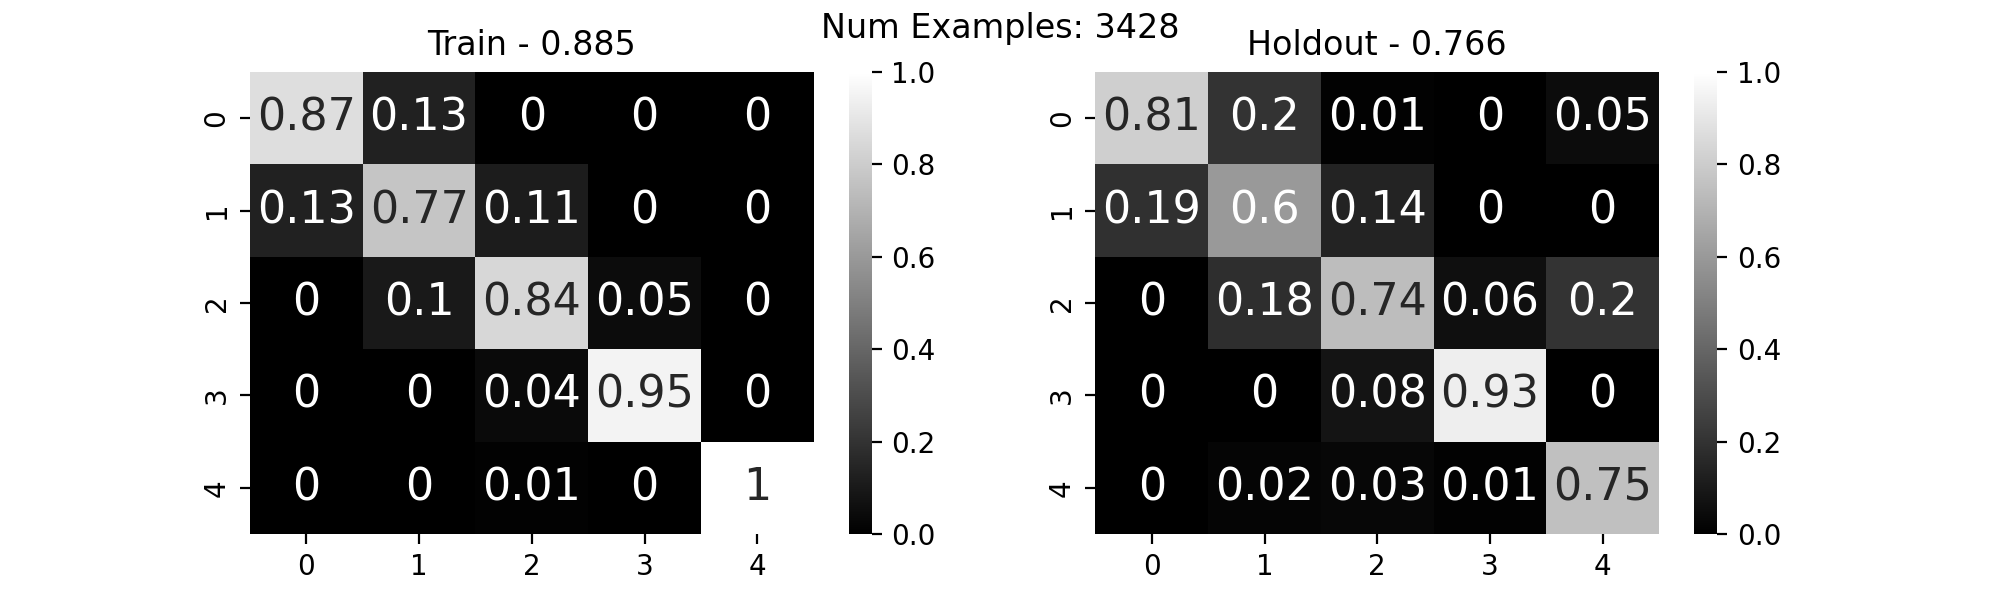

In [93]:
preproc = make_pipeline(
    StandardScaler(),
    PCA(),
)

classify = LogisticRegression(
    solver='lbfgs',
    fit_intercept=True, 
    class_weight='balanced',
    max_iter=10000,
    C=1
)

tr_acc, val_acc = [], []
n_train_lst = [1e1, 1e2, 1e3, 2e3, 3e3, 4e3]
for n_train in n_train_lst:
    pipe, n_train = pipeline.fit_n_train(features_train, labels_train, preproc, classify, preproc_refit=True, n_train=n_train)

    fig, ax = plt.subplots(1, 2, figsize=(10,3))
    fig.suptitle(f'Num Examples: {int(n_train)}')

    evaluator = evaluate.Evaluation(pipe.pipeline)
    cm = evaluator.confusion_matrix(features_train, labels_train)
    cm = np.round(cm, 2)
    acc = np.round(evaluator.score_classifier_logreg(features_train, labels_train), 3)
    tr_acc.append(acc)
    
    sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'), ax=ax[0])
    ax[0].set_title(f'Train - {acc}')

    evaluator = evaluate.Evaluation(pipe.pipeline)
    cm = evaluator.confusion_matrix(features_holdout, labels_holdout)
    cm = np.round(cm, 2)
    acc = np.round(evaluator.score_classifier_logreg(features_holdout, labels_holdout), 3)
    val_acc.append(acc)
    
    sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'), ax=ax[1])
    ax[1].set_title(f'Holdout - {acc}')

<IPython.core.display.Javascript object>


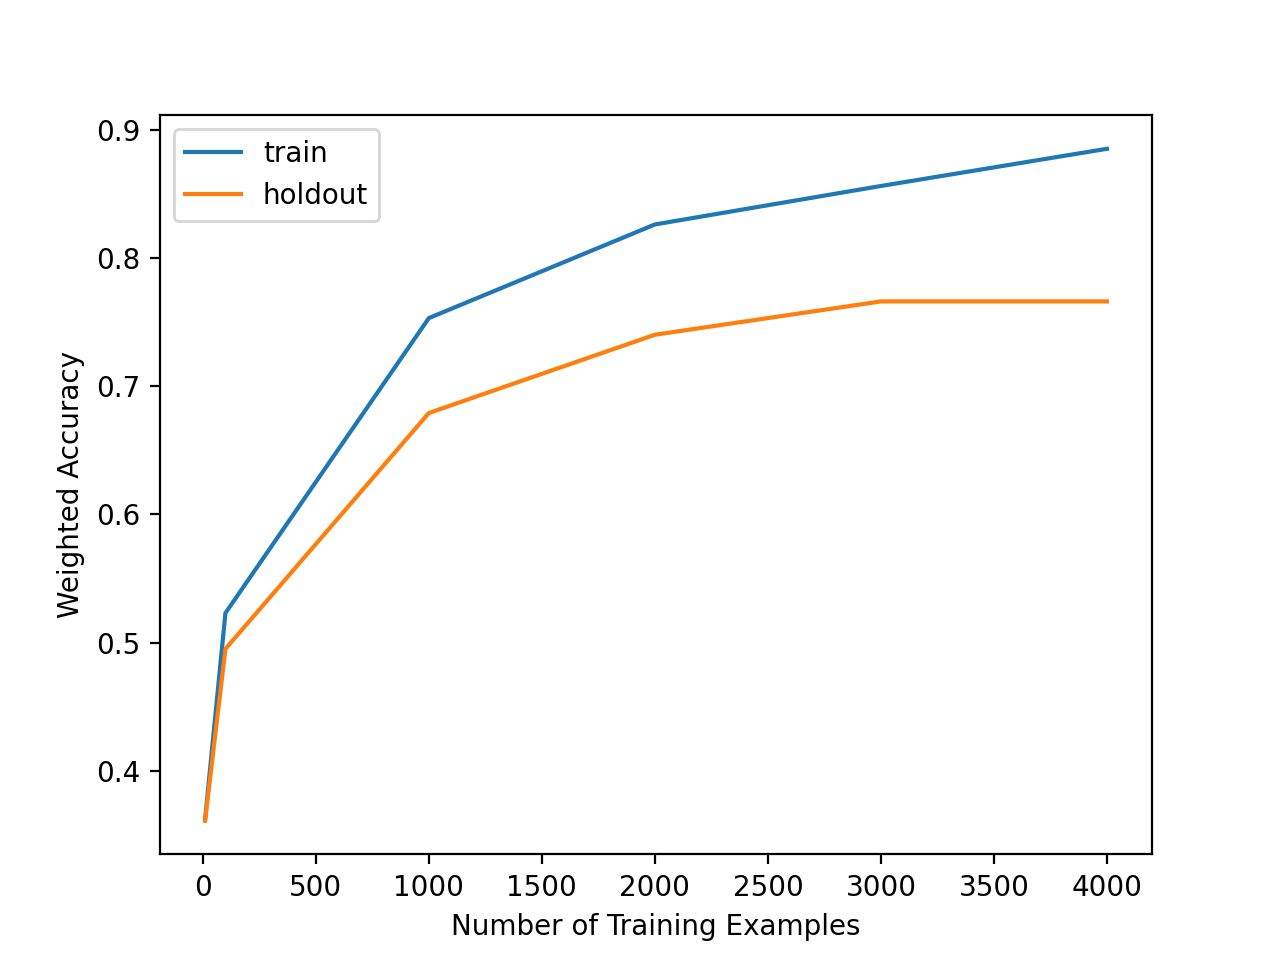

In [101]:
plt.figure()
plt.plot(n_train_lst,tr_acc,label='train')
plt.plot(n_train_lst,val_acc,label='holdout')
plt.xlabel('Number of Training Examples')
plt.ylabel('Weighted Accuracy')
plt.legend()

# Save Classifier After Refitting to All Data

In [ ]:
preproc = make_pipeline(
    StandardScaler(),
    PCA(),
)

classify = LogisticRegression(
    solver='lbfgs',
    fit_intercept=True, 
    class_weight='balanced',
    max_iter=10000,
    C=1
)

pipe = pipeline.fit_pipe(latents, labelFiles, preproc, classify, preproc_refit=True)

In [ ]:
# Save Pipeline
pipe.save('/Users/josh/Downloads/data_backup_save/pipe2.pkl')
# pipe.save('/n/data1/hms/neurobio/sabatini/josh/analysis/data_backup_save/pipe.pkl')